DIABETES PREDICTION
Dataset shape: (768, 9)
Target distribution: {0: 500, 1: 268}
Diabetic percentage: 34.9%
Glucose: 5 zeri sostituiti con NaN
BloodPressure: 35 zeri sostituiti con NaN
SkinThickness: 227 zeri sostituiti con NaN
Insulin: 374 zeri sostituiti con NaN
BMI: 11 zeri sostituiti con NaN


Features aggiunte: 6


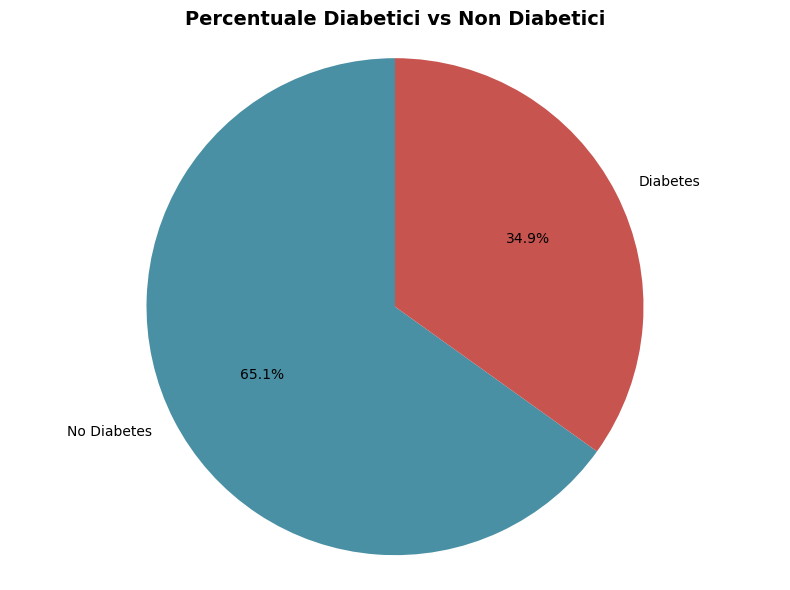

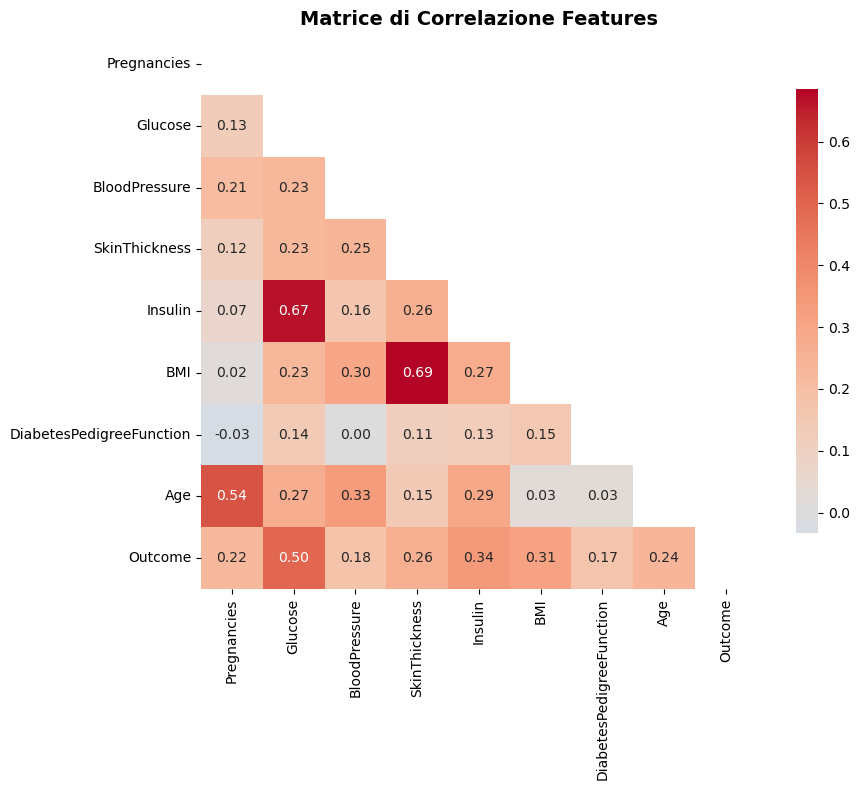

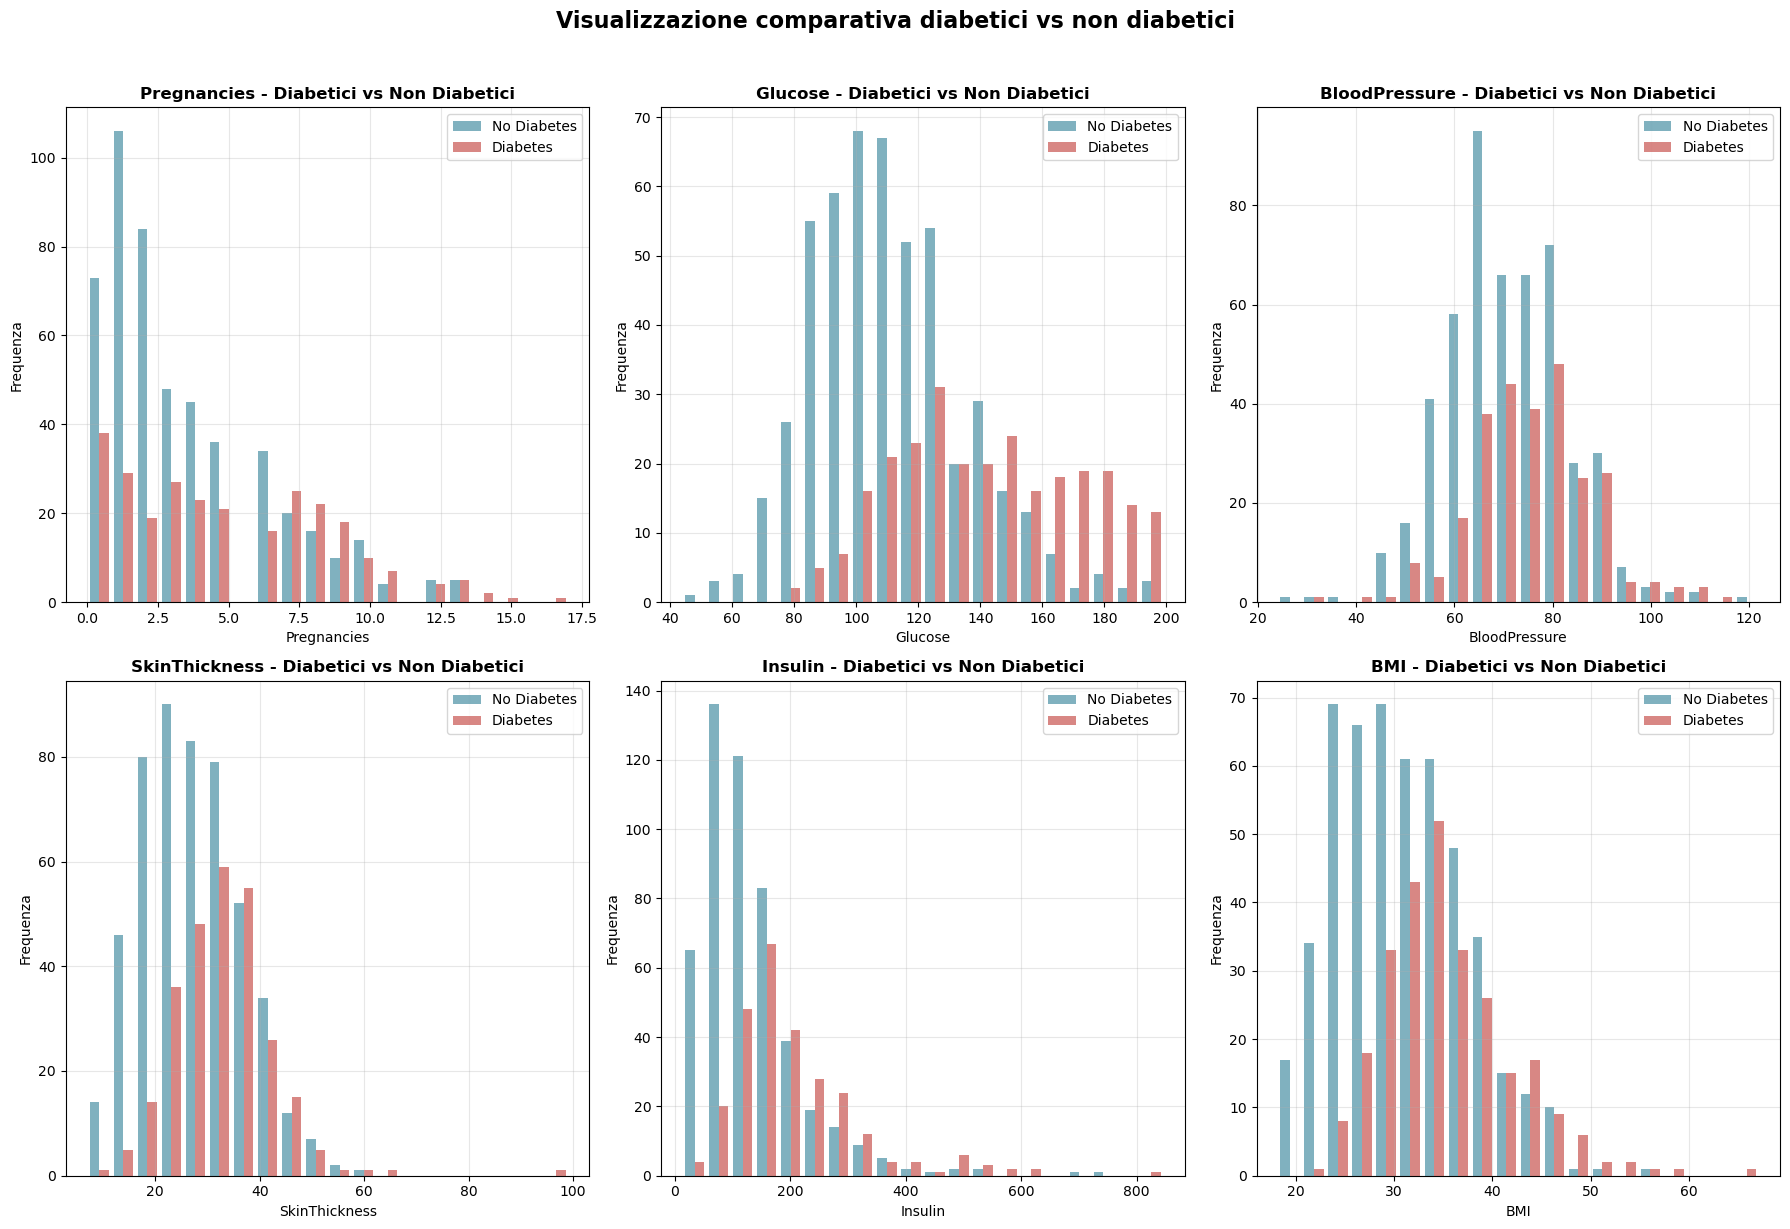

Dopo SMOTE: 800 samples, bilanciamento: [400 400]


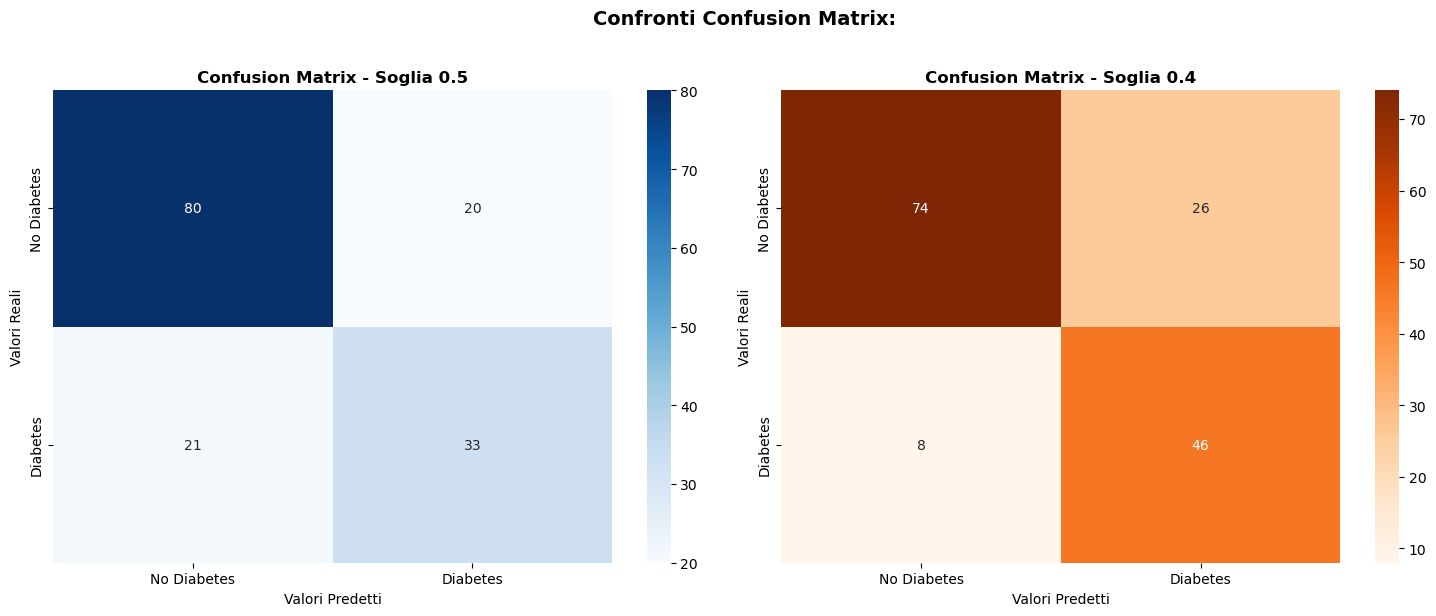


======================================== RISULTATI ========================================
Accuratezza (soglia 0.5): 0.734
Accuratezza (soglia 0.4): 0.779
AUC Score: 0.826
CV Score: 0.826 (+/- 0.148)
Recall diabetici (0.5): 0.611
Recall diabetici (0.4): 0.852
Miglioramento recall: +24.1pp

Classification Report (Soglia 0.4):
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       100
           1       0.64      0.85      0.73        54

    accuracy                           0.78       154
   macro avg       0.77      0.80      0.77       154
weighted avg       0.81      0.78      0.78       154



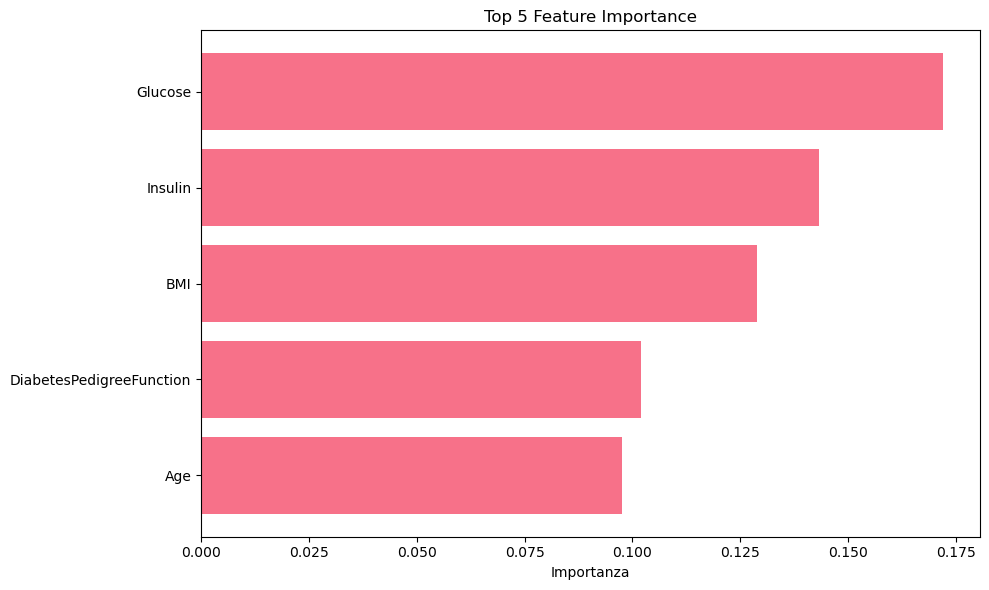

Top 5 Feature Importance:
                    feature  importance
1                   Glucose    0.171993
4                   Insulin    0.143373
5                       BMI    0.128778
6  DiabetesPedigreeFunction    0.102052
7                       Age    0.097571


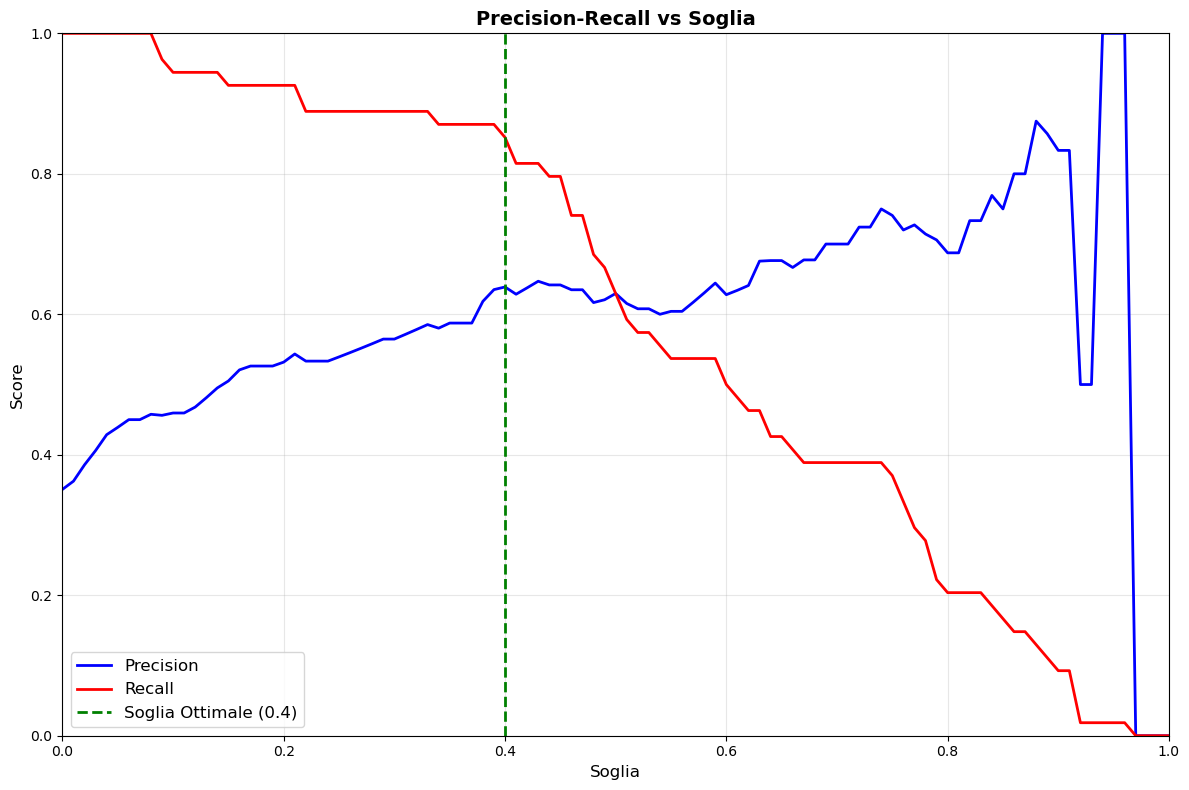

Analisi Precision-Recall vs Soglia:
Soglia 0.4: Precision=0.639, Recall=0.852

================================================== PREDIZIONE PERSONALIZZATA ==================================================
🤖 Il modello di predizione del diabete è pronto!
📊 Vuoi effettuare una predizione personalizzata con i tuoi dati?

Digita:
  - 'si' o 's' per inserire i tuoi dati
  - 'no' o 'n' per saltare questa sezione
  - qualsiasi altro tasto per uscire

✅ Predizione personalizzata saltata.
💡 Puoi sempre usare la funzione predict_diabetes() per fare predizioni programmatiche.

🎯 MODELLO PRONTO! Usa predict_diabetes() per nuove predizioni


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, recall_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')


# Configurazione
plt.style.use('default') # lo stile dei grafici di Matplotlib
sns.set_palette("husl") # palette di colori usata da Seaborn

print("="*50)
print("DIABETES PREDICTION")
print("="*50)

# 1. CARICAMENTO E ANALISI DATI
df = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df['Outcome'].value_counts().to_dict()}")
print(f"Diabetic percentage: {df['Outcome'].mean()*100:.1f}%")

# 2. GESTIONE VALORI MANCANTI
def preprocess_data(df):
    """Gestisce missing values e applica feature engineering"""
    df_clean = df.copy()

    # Sostituisci zeri anomali con NaN
    problematic_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for col in problematic_cols:
        if col in df_clean.columns:
            df_clean.loc[df_clean[col] == 0, col] = np.nan
            print(f"{col}: {(df[col] == 0).sum()} zeri sostituiti con NaN")

    # Imputazione con Random Forest
    features_to_impute = df_clean.drop('Outcome', axis=1)
    target = df_clean['Outcome'] #droppiamo outcome
    #n_estimators --> alberi random_state --> seme pseudorandom
    rf_imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=50, random_state=42),
        random_state=42, max_iter=10
    )
    #applichiamo l'imputer alle features
    imputed_features = rf_imputer.fit_transform(features_to_impute)
    df_imputed = pd.DataFrame(imputed_features, columns=features_to_impute.columns)
    df_imputed['Outcome'] = target.values
    #restituiamo il DF senza valori mancanti e l'imputatore
    return df_imputed, rf_imputer

df_clean, imputer = preprocess_data(df)
display(HTML('<span style="color: green; font-weight: bold;">Preprocessing completato</span>'))

# 3. FEATURE ENGINEERING
def add_medical_features(df):
    """
    Aggiunge feature derivate basate su soglie cliniche e interazioni tra fattori di rischio.

    Parametri:
    -----------
    df : pandas.DataFrame
    Restituisce:
    -----------
    pandas.DataFrame
        Una copia del DataFrame originale con colonne aggiuntive:
        - 'Glucose_risk': 1 se 'Glucose' > 125 mg/dL, 0 altrimenti.
        - 'BMI_obese': 1 se 'BMI' > 30, 0 altrimenti.
        - 'Age_high_risk': 1 se 'Age' > 45 anni, 0 altrimenti.
        - 'BP_high': 1 se 'BloodPressure' > 90 mmHg, 0 altrimenti.
        - 'Glucose_BMI_risk': prodotto di 'Glucose_risk' e 'BMI_obese', indica rischio combinato.
        - 'Age_Glucose_risk': prodotto di 'Age_high_risk' e 'Glucose_risk', indica rischio combinato.

    Note:
    -----
    - Le soglie usate sono basate su conoscenze mediche comuni per il diabete e fattori di rischio correlati.
    - La colonna 'BloodPressure' indica la pressione arteriosa
    - Le feature di interazione catturano l'effetto combinato di più fattori di rischio.
    """
    df_new = df.copy()

    # Categorie di rischio medico
    df_new['Glucose_risk'] = (df['Glucose'] > 125).astype(int) #serie booleana. True se il valore è sopra soglia, false se è più basso
    df_new['BMI_obese'] = (df['BMI'] > 30).astype(int)
    df_new['Age_high_risk'] = (df['Age'] > 45).astype(int)
    df_new['BP_high'] = (df['BloodPressure'] > 90).astype(int)

    # Interazioni
    df_new['Glucose_BMI_risk'] = df_new['Glucose_risk'] * df_new['BMI_obese']
    df_new['Age_Glucose_risk'] = df_new['Age_high_risk'] * df_new['Glucose_risk']

    return df_new

df_enhanced = add_medical_features(df_clean)
print(f"Features aggiunte: {df_enhanced.shape[1] - df_clean.shape[1]}") #stampiamo il numero di colonne aggiunte


# Target distribution (Pie Chart)
plt.figure(figsize=(8, 6))
outcome_counts = df['Outcome'].value_counts()
colors = ['#4A90A4', '#C85450']
plt.pie(outcome_counts.values, labels=['No Diabetes', 'Diabetes'],
        colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentuale Diabetici vs Non Diabetici', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Correlation heatmap (dati puliti)

corr_matrix = df_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Matrice di Correlazione Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



# Distribuzione comparativa per tutte le features principali
features_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

colors = ['#4A90A4', '#C85450']
for i, feature in enumerate(features_to_plot):
    diabetic = df_clean[df_clean['Outcome'] == 1][feature] #prendiamo i diabetici
    non_diabetic = df_clean[df_clean['Outcome'] == 0][feature]

    axes[i].hist([non_diabetic, diabetic], bins=20, alpha=0.7,
                label=['No Diabetes', 'Diabetes'], color=colors)
    axes[i].set_title(f'{feature} - Diabetici vs Non Diabetici', fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequenza')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Visualizzazione comparativa diabetici vs non diabetici',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 5. PREPARAZIONE MODELLO
X = df_enhanced.drop('Outcome', axis=1)
y = df_enhanced['Outcome']
 #utilizziamo 80% per il training e 20% per il test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling e SMOTE
scaler = StandardScaler() #standardizziamo i valori delle features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#con SMOTE creiamo "pazienti sintetici" diabetici per bilanciare il DS
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Dopo SMOTE: {len(y_train_smote)} samples, bilanciamento: {np.bincount(y_train_smote)}")

# 6. TRAINING MODELLO
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    class_weight={0: 1, 1: 2},
    n_jobs=-1
)

rf_model.fit(X_train_smote, y_train_smote)

# 7. VALUTAZIONE CON SOGLIA OTTIMIZZATA
optimal_threshold = 0.4

y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_standard = rf_model.predict(X_test_scaled)
y_test_pred_optimized = (y_test_proba > optimal_threshold).astype(int)

# Confusion Matrix Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix - Soglia 0.5
cm_standard = confusion_matrix(y_test, y_test_pred_standard)
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
axes[0].set_title('Confusion Matrix - Soglia 0.5', fontweight='bold')
axes[0].set_xlabel('Valori Predetti')
axes[0].set_ylabel('Valori Reali')

# Confusion Matrix - Soglia 0.4
cm_optimized = confusion_matrix(y_test, y_test_pred_optimized)
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
axes[1].set_title('Confusion Matrix - Soglia 0.4', fontweight='bold')
axes[1].set_xlabel('Valori Predetti')
axes[1].set_ylabel('Valori Reali')

plt.suptitle('Confronti Confusion Matrix:', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Metriche
test_acc_standard = accuracy_score(y_test, y_test_pred_standard) #Accuracy soglia 0.5
test_acc_optimized = accuracy_score(y_test, y_test_pred_optimized) #accuracy soglia 0.4
auc_score = roc_auc_score(y_test, y_test_proba) #capacità modello distinguere tra positivi e negativi Varia tra 0.5 (Random) a 1 cioè perfetto
cv_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=10) # dividiamo il training in più fold. Per ciascuno. Io l'ho aumentato da 5 a 20. Oltre questo numero f1 non varia

recall_standard = recall_score(y_test, y_test_pred_standard)
recall_optimized = recall_score(y_test, y_test_pred_optimized)

print(f"\n{'='*40} RISULTATI {'='*40}")
print(f"Accuratezza (soglia 0.5): {test_acc_standard:.3f}")
print(f"Accuratezza (soglia {optimal_threshold}): {test_acc_optimized:.3f}")
print(f"AUC Score: {auc_score:.3f}")
print(f"CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print(f"Recall diabetici (0.5): {recall_standard:.3f}")
print(f"Recall diabetici ({optimal_threshold}): {recall_optimized:.3f}")
print(f"Miglioramento recall: +{(recall_optimized - recall_standard)*100:.1f}pp")

# Classification reports
print(f"\nClassification Report (Soglia {optimal_threshold}):")
print(classification_report(y_test, y_test_pred_optimized))

# 8. FEATURE IMPORTANCE
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(5)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importanza')
plt.title('Top 5 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 5 Feature Importance:")
print(feature_importance)

# ANALISI PRECISION-RECALL vs SOGLIA
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_thresh = (y_test_proba >= threshold).astype(int)

    if len(np.unique(y_pred_thresh)) == 1:
        if y_pred_thresh[0] == 1:
            precision = (y_test == 1).sum() / len(y_test)
            recall = 1.0
        else:
            precision = 0.0
            recall = 0.0
    else:
        from sklearn.metrics import precision_score
        precision = precision_score(y_test, y_pred_thresh, zero_division=0)
        recall = recall_score(y_test, y_pred_thresh, zero_division=0)

    precisions.append(precision)
    recalls.append(recall)

# Grafico Precision-Recall vs Soglia
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions, 'b-', linewidth=2, label='Precision')
plt.plot(thresholds, recalls, 'r-', linewidth=2, label='Recall')
plt.axvline(x=optimal_threshold, color='green', linestyle='--', linewidth=2,
            label=f'Soglia Ottimale ({optimal_threshold})')
plt.xlabel('Soglia', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision-Recall vs Soglia', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"Analisi Precision-Recall vs Soglia:")
print(f"Soglia {optimal_threshold}: Precision={precisions[int(optimal_threshold*100)]:.3f}, Recall={recalls[int(optimal_threshold*100)]:.3f}")

# 10. FUNZIONE PREDIZIONE INTERATTIVA
def predict_diabetes(pregnancies, glucose, blood_pressure, skin_thickness,
                    insulin, bmi, diabetes_pedigree, age, threshold=0.4):
    """Predice diabete con preprocessing completo"""

    # Input data
    input_data = pd.DataFrame({
        'Pregnancies': [pregnancies], 'Glucose': [glucose],
        'BloodPressure': [blood_pressure], 'SkinThickness': [skin_thickness],
        'Insulin': [insulin], 'BMI': [bmi],
        'DiabetesPedigreeFunction': [diabetes_pedigree], 'Age': [age]
    })

    # Gestione valori anomali (0 dove non dovrebbero essere)
    problematic_cols = ['Glucose', 'BloodPressure', 'BMI']
    for col in problematic_cols:
        if input_data[col].iloc[0] == 0:
            input_data.loc[0, col] = df_clean[col].mean()

    # Feature engineering
    input_enhanced = add_medical_features(input_data)

    # Allinea colonne
    for col in X.columns:
        if col not in input_enhanced.columns:
            input_enhanced[col] = 0
    input_enhanced = input_enhanced[X.columns]

    # Scaling e predizione
    input_scaled = scaler.transform(input_enhanced)
    probability = rf_model.predict_proba(input_scaled)[0, 1]
    prediction = (probability > threshold).astype(int)

    # Livello rischio
    if probability < 0.3:
        risk_level = "BASSO"
    elif probability < 0.7:
        risk_level = "MODERATO"
    else:
        risk_level = "ALTO"

    return prediction, probability, risk_level

# 11. PREDIZIONE PERSONALIZZATA CON RICHIESTA UTENTE
print(f"\n{'='*50} PREDIZIONE PERSONALIZZATA {'='*50}")

# Chiedi all'utente se vuole effettuare una predizione
print("🤖 Il modello di predizione del diabete è pronto!")
print("📊 Vuoi effettuare una predizione personalizzata con i tuoi dati?")
print("\nDigita:")
print("  - 'si' o 's' per inserire i tuoi dati")
print("  - 'no' o 'n' per saltare questa sezione")
print("  - qualsiasi altro tasto per uscire")

user_choice = input("\nVuoi inserire i tuoi dati?: ").lower().strip()

if user_choice in ['si', 's', 'sì', 'yes', 'y']:
    print(f"\n{'='*40} INSERIMENTO DATI {'='*40}")
    print("Inserisci i tuoi dati per ottenere una predizione personalizzata:")
    print("(Inserisci 0 se non conosci il valore - verrà sostituito automaticamente)\n")

    try:
        pregnancies = float(input("Numero di gravidanze: "))
        glucose = float(input("Livello di glucosio (mg/dL): "))
        blood_pressure = float(input("Pressione sanguigna (mmHg): "))
        skin_thickness = float(input("Spessore della pelle (mm): "))
        insulin = float(input("Insulina (μU/mL): "))
        bmi = float(input("BMI (kg/m²): "))
        diabetes_pedigree = float(input("Diabetes Pedigree Function (0-2): "))
        age = float(input("Età (anni): "))

        # Esegui predizione
        prediction, probability, risk_level = predict_diabetes(
            pregnancies, glucose, blood_pressure, skin_thickness,
            insulin, bmi, diabetes_pedigree, age
        )

        print(f"\n{'='*30} RISULTATI {'='*30}")
        print(f"📊 PREDIZIONE: {'🔴 DIABETE' if prediction == 1 else '🟢 NO DIABETE'}")
        print(f"📈 PROBABILITÀ: {probability:.1%}")
        print(f"⚠️  LIVELLO RISCHIO: {risk_level}")

        if risk_level == "ALTO":
            print("\n💡 RACCOMANDAZIONE: Consulta un medico per approfondimenti")
        elif risk_level == "MODERATO":
            print("\n💡 RACCOMANDAZIONE: Monitora i valori e mantieni uno stile di vita sano")
        else:
            print("\n💡 RACCOMANDAZIONE: Continua con uno stile di vita sano")

    except (ValueError, KeyboardInterrupt):
        print("\n⚠️ Input non valido o operazione annullata.")
        print("Usa la funzione predict_diabetes() per predizioni programmatiche.")

elif user_choice in ['no', 'n']:
    print("\n✅ Predizione personalizzata saltata.")
    print("💡 Puoi sempre usare la funzione predict_diabetes() per fare predizioni programmatiche.")

else:
    print("\n👋 Arrivederci!")
    print("💡 Il modello rimane disponibile per predizioni future con predict_diabetes().")

print(f"\n{'='*80}")
print("🎯 MODELLO PRONTO! Usa predict_diabetes() per nuove predizioni")
print(f"{'='*80}")